In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [55]:
total_data = pd.read_csv('1.csv').astype(str)
test = pd.read_csv('2.csv').astype(str)

In [56]:
print(total_data.isnull().values.any())

False


In [57]:
change_value_dict = {'판단유보':0,'전혀 사실 아님' : 0,'대체로 사실 아님' : 0.25,'절반의 사실' : 0.5,'대체로 사실' : 0.75, '사실' : 1}
total_data = total_data.replace({'level' : change_value_dict})

In [58]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 195
테스트용 리뷰의 개수 : 65


<AxesSubplot:>

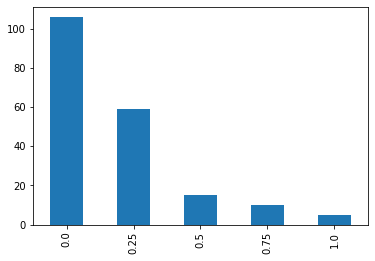

In [59]:
train_data['level'].value_counts().plot(kind = 'bar')

In [60]:
print(train_data.groupby('level').size().reset_index(name = 'count'))

   level  count
0   0.00    106
1   0.25     59
2   0.50     15
3   0.75     10
4   1.00      5


In [40]:
train_data['title'] = train_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['title'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

title    0
level    0
dtype: int64
<ipython-input-40-b1851d2de38e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['title'] = train_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-40-b1851d2de38e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['title'] = train_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [62]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [63]:
test_data.drop_duplicates(subset = ['title'], inplace=True) # 중복 제거
test_data['title'] = test_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 65
<ipython-input-63-ed6ea618542b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['title'], inplace=True) # 중복 제거
<ipython-input-63-ed6ea618542b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['title'] = test_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-63-ed6ea618542b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['title'] = test_data['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [64]:
mecab = Mecab() 

train_data['tokenized'] = train_data['title'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['title'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

<ipython-input-64-c36de010249f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['title'].apply(mecab.morphs)
<ipython-input-64-c36de010249f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [65]:
negative_words = np.hstack(train_data[train_data.level == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.level == 1]['tokenized'].values)

In [66]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('코로나', 53), ('백신', 29), ('있', 17), ('에서', 17), ('한다', 13), ('바이러스', 13), ('로', 12), ('자', 11), ('적', 11), ('신종', 11), ('없', 10), ('접종', 9), ('수', 9), ('마스크', 9), ('받', 8), ('중국', 8), ('감염', 8), ('으로', 8), ('했', 8), ('검사', 7)]


In [67]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('코로나', 4), ('마스크', 2), ('된다', 2), ('않', 2), ('개인', 1), ('소비자', 1), ('사재기', 1), ('해도', 1), ('단속', 1), ('확진', 1), ('자', 1), ('격리', 1), ('해제', 1), ('시', 1), ('경우', 1), ('따라', 1), ('유전자', 1), ('증폭', 1), ('검사', 1), ('받', 1)]


긍정 리뷰의 평균 길이 : 9.6
부정 리뷰의 평균 길이 : 9.349056603773585


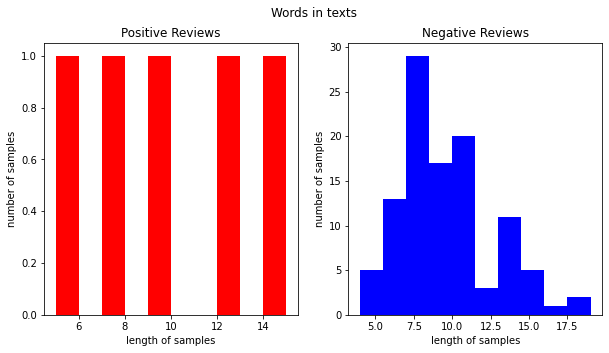

In [68]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['level']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['level']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [69]:
X_train = train_data['tokenized'].values
y_train = train_data['level'].values
X_test= test_data['tokenized'].values
y_test = test_data['level'].values


In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [71]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 803
등장 빈도가 1번 이하인 희귀 단어의 수: 560
단어 집합에서 희귀 단어의 비율: 69.7384806973848
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 31.478358628442944


In [72]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 245


AttributeError: 'int' object has no attribute 'lower'

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)